In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import mikkel_tools.GMT_tools as gt

# ChaosMagPy modules
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000
from chaosmagpy.model_utils import design_gauss

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

from math import atan2, sin, cos, sqrt, pi

comment = "Swarm observations test of entropy"
nb_name = "nb_entropy_test"

In [2]:
def define_icosahedral_grid():
    """
    Creates a 3d icosahedral grid. It has 20 faces and 12 vertices.

    Args:

    Returns:
        icosahedral_points (float list): list of tuples with 3d-coordinates for the vertices
        icosahedral_triangles (int list): list of tuples with indices referring to which points that makes up each triangle

    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """
    # generate base icosahedral grid
    s, c = 2 / sqrt(5), 1 / sqrt(5)

    # get all top points for triangles in icosahedral grid
    top_points = [(0, 0, 1)] + [(s * cos(i * 2 * pi / 5.), s * sin(i * 2 * pi / 5.), c) for i in range(5)]

    # get all bottom points for triangles in icosahedral grid
    bottom_points = [(-x, y, -z) for (x, y, z) in top_points]

    icosahedral_points = top_points + bottom_points

    # get indices pointing out each triangle made up by the icosahedral points
    icosahedral_triangles = [(0, i + 1, (i + 1) % 5 + 1) for i in range(5)] + \
                            [(6, i + 7, (i + 1) % 5 + 7) for i in range(5)] + \
                            [(i + 1, (i + 1) % 5 + 1, (7 - i) % 5 + 7) for i in range(5)] + \
                            [(i + 1, (7 - i) % 5 + 7, (8 - i) % 5 + 7) for i in range(5)]

    return icosahedral_points, icosahedral_triangles


def refine_triangle(refinement_degree):
    """
    This funcion refines a equilateral unit triangle based on input refinement degree. Based on the idea
    of finding midpoints between neighboring points within each sub triangle
           2
          /\
         /  \
    mp02/____\mp12       Construct new triangles
       /\    /\
      /  \  /  \
     /____\/____\
    0    mp01    1

    Args:
        refinement_degree (int): the degree of triangle refinement

    Returns:
        fixed_triangle (float ndarray): the (x, y)-vertices for refined fixed 2d triangle.
        fixed_hexagon (float ndarray): the (x, y)-vertices for refined fixed 2d hexagon.
        n_points (int): total number of points in grid


    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """

    # define fixed unit triangle
    fixed_triangle = np.array([[[-0.5, 0], [0.5, 0], [0, sqrt(3) / 2]]])

    # duplicate fixed triangle for refinement
    refined_triangle = fixed_triangle

    # Loop refines triangle iteratively into 4 sub triangles per loop
    for i in range(refinement_degree):
        if refinement_degree == 0:  # no refinement
            break

        mp01 = (refined_triangle[:, 0, :] + refined_triangle[:, 1, :]) / 2
        mp02 = (refined_triangle[:, 0, :] + refined_triangle[:, 2, :]) / 2
        mp12 = (refined_triangle[:, 1, :] + refined_triangle[:, 2, :]) / 2

        # collect the points of each of the 4 subtriangles
        t1 = np.array(list(zip(refined_triangle[:, 0, :], mp01, mp02)))
        t2 = np.array(list(zip(refined_triangle[:, 1, :], mp12, mp01)))
        t3 = np.array(list(zip(refined_triangle[:, 2, :], mp02, mp12)))
        t4 = np.array(list(zip(mp01, mp12, mp02)))

        refined_triangle = np.concatenate((t1, t2, t3, t4), axis=0)

    # midpoints of triangles are hexagon vertices, found by:
    fixed_hexagon = np.sum(refined_triangle, axis=1) / 3

    n_points = 3 * 4 ** refinement_degree  # number of points (no. of triangles in refinement * 3)

    fixed_triangle = np.resize(refined_triangle, (n_points, 2))  # resize into a single list

    fixed_triangle = np.unique(fixed_triangle, axis=0)  # removes duplicate coordinates (local xy)

    return fixed_triangle, fixed_hexagon, n_points

def project_grid_to_sphere(refined_grid, icosahedral_vertices, icosahedral_triangles, indices,
                           spherical_coordinates=True):
    """
    Projects a icosahedral grid (2d) onto a sphere. It works through each triangle (face) in the icosahedral grid and
    creates a grid inside that triangle based on the refined grid.
    If spherical_coords are set to True, the icosahedral vertices coordinates are returned in spherical coordinates
    (radians)

    Args:
        refined_vertices (float ndarray): the (x, y)-vertices for refined fixed 2d triangle.
        refined_indices (int ndarray): array of indices corrsponding to the vertices in the refined triangles
        icosahedral_vertices (float ndarray): the 2d icosahedral grid (x, y)-vertices.
        icosahedral_indices (float ndarray): indices of the vertices of the icoshedral grid triangles
        spherical_coordinates (boolean): return vertices coordinates in spherical (True, default) or cartisian coordinates (False)

    Returns:
        icosahedral_sphere: 3d spherical grid (x, y, z) as (n, 3)-array where n is number of points
        icosahedral_indices: indices pointing to coordinates, one per face.

    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """

    # project triangular grid in 2d onto sphere
    n_vertices = len(refined_grid)  # number of vertices
    n_faces = len(indices)  # number of faces
    icosahedral_sphere = np.zeros((20 * n_vertices, 3))
    icosahedral_faces = np.zeros((20 * n_faces, 3))

    for j in range(20):
        s1 = icosahedral_vertices[icosahedral_triangles[j][0]]
        s2 = icosahedral_vertices[icosahedral_triangles[j][1]]
        s3 = icosahedral_vertices[icosahedral_triangles[j][2]]
        for i in range(n_vertices):
            p = [refined_grid[i, 0], refined_grid[i, 1]]  # 2D point to be mapped to sphere
            icosahedral_sphere[n_vertices * j + i, :] = _map_gridpoint_to_sphere(p, s1, s2, s3)

        icosahedral_faces[(n_faces * j):(n_faces * (j + 1)), :] = indices + j * n_vertices

    # print(icosahedral_sphere)
    icosahedral_faces = icosahedral_faces.astype(int)

    # convert xyz to spherical coordinates
    if spherical_coordinates:
        xy_tmp = icosahedral_sphere[:, 0] ** 2 + icosahedral_sphere[:, 1] ** 2  # enabling swapping arccos with arctan2
        r = np.sqrt(xy_tmp + icosahedral_sphere[:, 1] ** 2)
        phi = np.arctan2(icosahedral_sphere[:, 1], icosahedral_sphere[:, 0])
        theta = np.arctan2(np.sqrt(xy_tmp), icosahedral_sphere[:, 2])
        icosahedral_sphere = np.array([r, theta, phi]).T

    # in order to not count points on the border between triangles several times, we have to round to get all duplicates
    icosahedral_sphere = np.unique(np.round(icosahedral_sphere, decimals=10), axis=0)

    return icosahedral_sphere, icosahedral_faces

def _get_indices(fixed_triangle, fixed_hexagon):
    """
    Takes the points in a icoshedral grid and find the indices corresponding to the vertices.

    Args:
        fixed_triangle (float ndarray): the (x, y)-vertices for refined fixed 2d triangle.
        fixed_hexagon (float ndarray): the (x, y)-vertices for refined fixed 2d hexagon.

    Returns:
        indices (int ndarray): array of indices corrsponding to the vertices in the refined triangles

    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """

    dist_xy = fixed_triangle[:, :, None] - np.transpose(fixed_hexagon)
    dist = (np.sum(dist_xy ** 2, axis=1)).round(10)  # no need to take sqrt
    indices = np.where(dist.transpose() == dist.min())  # indices of minimum values
    indices = np.reshape(indices[1], (-1, 3))

    return indices

def _map_gridpoint_to_sphere(p, s1, s2, s3):
    """
    Computes Spherical Linear Interpolation based on the arc defined by the
    coordinates given by p0 and p1 (around origin)

    Args:
        p (float, list of tuples): (x,y)-coordinates in list
        s1 (float, list): vertices length N
        s2 (float, list): vertices length N
        s3 (float, list): vertices length N

    Returns:
        _slerp(p12, s3, lambda3): The double slerp'ed points

    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """
    # map 2D point p to spherical triangle s1, s2, s3 (3D vectors of equal length)
    lambda1, lambda2, lambda3 = _barycentric_coords(p)
    if abs(lambda3 - 1) < 1e-10:
        return s3
    lambda2s = lambda2 / (lambda1 + lambda2)
    p12 = _slerp(s1, s2, lambda2s)
    return _slerp(p12, s3, lambda3)

def _barycentric_coords(p):
    """
    Computes barycentric coordinates for triangle, given a (x, y) point.
    Triangle given by: (-0.5,0),(0.5,0),(0,sqrt(3)/2)
    Barycentric coordinates describes every point inside a triangle r by the convex combination of its three vertices r1, r2 and r3:
    r = lambda1*r1 + lambda2*r2 + lambda3*r3
    Where lambda1 + lambda2 + lambda3 = 1 and lambda1, lambda2, lambda3 >= 0

    Args:
        p (float, tuple): (x,y)-coordinate of the point to be mapped into barycentric coordinates

    Returns:
        lambda1 (float): barycentric coordinate
        lambda2 (float): barycentric coordinate
        lambda3 (float): barycentric coordinate

    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """
    x, y = p
    lambda3 = y * 2. / sqrt(3.)  # lambda3*sqrt(3)/2 = y
    lambda2 = x + 0.5 * (1 - lambda3)  # 0.5*(lambda2 - lambda1) = x
    lambda1 = 1 - lambda2 - lambda3  # lambda1 + lambda2 + lambda3 = 1
    return lambda1, lambda2, lambda3

def _slerp(p0, p1, t):
    """
    Computes Spherical Linear Interpolation based on the arc defined by the
    coordinates given by p0 and p1 (around origin)

    Args:
        p0 (float, list of tuples): (x,y)-coordinates in list
        p1 (float, list of tuples): (x,y)-coordinates in list
        t (float): projection weighting based on coordinate point position: t: t=0 -> p0, t=1 -> p1

    Returns:
        tuple([(l0 * p0[i] + l1 * p1[i]) / ang0_sin for i in range(len(p0))]): the projected points

    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """
    # uniform interpolation of arc defined by p0, p1 (around origin)
    # t=0 -> p0, t=1 -> p1
    assert abs(_scalar_product(p0, p0) - _scalar_product(p1, p1)) < 1e-7
    ang0_cos = _scalar_product(p0, p1) / _scalar_product(p0, p0)
    ang0_sin = sqrt(1 - ang0_cos * ang0_cos)
    ang0 = atan2(ang0_sin, ang0_cos)

    # weight project given t: t=0 -> p0, t=1 -> p1
    l0 = sin((1 - t) * ang0)
    l1 = sin(t * ang0)
    return tuple([(l0 * p0[i] + l1 * p1[i]) / ang0_sin for i in range(len(p0))])

def _scalar_product(p1, p2):
    """
    Helping function for computing the arc used in Spherical Linear Interpolation.
    Computes the sum of coordinate points

    Args:
        p1 (float, list of tuples): (x,y)-coordinates in list
        p2 (float, list of tuples): (x,y)-coordinates in list

    Returns:
        sum([p1[i] * p2[i] for i in range(len(p1))])

    Originally adopted from a comment from
    https://stackoverflow.com/questions/46777626/mathematically-producing-sphere-shaped-hexagonal-grid by user 'coproc'
    (3/10/2018)
    @author: Stefan Krebs Lange-Willman <s140447@student.dtu.dk>
    @edit: Eigil Y. H. Lippert <s132561@student.dtu.dk>
    """
    return sum([p1[i] * p2[i] for i in range(len(p1))])

In [3]:

def grid_icosahedral_eigil(refinement_degree = 4, radius = 3480.0, delete_pole_points=True):
    """
    Computes an icosahedral spherical grid.
    Returns a grid in co-latitude [0;180] (theta_grid) and longitude (phi_grid) [-180;180] in degrees.

    The relation between number of grid points and refinement degree is:
         icosahedral: Npoints = 2 + 10 * 4 ** refinement_degree

    Args:
        refinement_degree (int): harmonic degree
        radius: grid radius
        delete_pole_points (boolean): Choose to remove grid points at north and south pole, default True

    Returns:
        grid_radial (float ndarray):
        grid_theta (float ndarray):
        grid_phi (float ndarray):

    @author: Eigil Y. H. Lippert, Student DTU Space, <s132561@student.dtu.dk>
    @adapted: Mikkel Otzen, PhD Student DTU Space, mikotz@space.dtu.dk
    """

    # compute icosahedral grid
    icos_points, icos_triangs = define_icosahedral_grid()

    # create base triangle and refine to chosen degree
    fixed_triangle, fixed_hexagon, n_points = refine_triangle(refinement_degree)

    # get indices of all faces
    indices = _get_indices(fixed_triangle, fixed_hexagon)

    # project onto sphere
    icosahedral_sphere, icos_faces = project_grid_to_sphere(fixed_triangle, icos_points, icos_triangs, indices)

    theta, phi = icosahedral_sphere[:, 1], icosahedral_sphere[:, 2]

    # convert to degrees
    grid_theta = theta * 180 / np.pi
    grid_phi = phi * 180 / np.pi

    if delete_pole_points:
        pole_idx_n = np.where(np.round(grid_theta, 6) == 0)
        grid_theta = np.delete(grid_theta, pole_idx_n)
        grid_phi = np.delete(grid_phi, pole_idx_n)

        pole_idx_s = np.where(np.round(grid_theta, 6) == 180)
        grid_theta = np.delete(grid_theta, pole_idx_s)
        grid_phi = np.delete(grid_phi, pole_idx_s)
        
    grid_radial = np.ones(grid_theta.shape)*radius
    
    return grid_radial, grid_theta, grid_phi

In [4]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

grid_radial, grid_theta, grid_phi = grid_icosahedral_eigil(refinement_degree = 4, radius = core.r_cmb, delete_pole_points=True)

core.grid_radial = grid_radial
core.grid_theta = grid_theta
core.grid_phi = grid_phi

#core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

In [5]:
Gr_cmb, _, _ = design_gauss(core.grid_radial, core.grid_theta, core.grid_phi, shc_g)
#G = np.vstack((Gr,Gt,Gp))
#print(G.shape)

In [6]:
print(core)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Swarm observations test of entropy
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core_ens
grid_radial:      (2560,), Max/Min: 3480.00 / 3480.00
grid_theta:       (2560,), Max/Min: 176.04 / 3.96
grid_phi:         (2560,), Max/Min: 180.00 / -178.84



# 1 year, 6nT C_e, SV removed

In [7]:
#shc_g = 30
#shc_grid = 30
#
#str_load = "Ce6_PT5M_Sy2018m11d1_Ey2019m11d1_Np500"
#C_e_const = 6
#samp = "PT5M"
#date_start = [2018,11,1]
#date_end = [2019,11,1]
#
#file_pickle = open("{}_{}.obj".format(nb_name,str_load), 'rb')
#core = pickle.load(file_pickle)
#file_pickle.close()
#core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
#grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
#core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
#core.generate_map()

In [8]:
samp = "PT5M"
date_start = [2018,11,1]
date_end = [2019,4,1]

In [9]:
# Swarm obs
import datetime as dt
from viresclient import SwarmRequest
request = SwarmRequest()
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst", "IMF_BZ_GSM"]
use_models = ["LCS1='LCS-1'(min_degree=1, max_degree=185)", "CHAOS-MMA", "MIO_SHA_2C"] # "CHAOS='CHAOS-Core'(min_degree=15, max_degree=20)"
request.set_collection(collect)
request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step=samp)

data = request.get_between(start_time=dt.datetime(date_start[0],date_start[1],date_start[2]),
                           end_time=dt.datetime(date_end[0],date_end[1],date_end[2]))
ds = data.as_xarray()
SZA_angle = 120
Kp_max = 2
dDst_dt_max = 2
Dst_abs_max = 30
QDlat_max = 90
IMF_BZ_min = 0.0
dDst_dt = (abs(np.diff(ds.Dst.values,prepend=0))/5)*60 #(nT/5min)/5 * 60min/hr -> nT/hr
Dst_abs = abs(ds.Dst.values)
idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  dDst_dt<=dDst_dt_max, Dst_abs < Dst_abs_max,
                                  ds.IMF_BZ_GSM>IMF_BZ_min))

obs_sat = SDSS(comment, N_SH = shc_g)
obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.lat)
print(obs_sat.grid_N)

[1/1] Processing:  100%|██████████|  [ Elapsed: 01:30, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (7.471MB)


1988


In [6]:
#print(ds)

In [10]:
# chaosmagpy
N_chaos = 14
CHAOS7 = load_CHAOS_matfile('mikkel_tools/models_shc/CHAOS-7.mat')
# Start
chaos_time = mjd2000(date_start[0],date_start[1],date_start[2])
g_CHAOS7 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=N_chaos, deriv=0)
A_r, A_theta, A_phi = gt.design_SHA(obs_sat.r_grid/core.a, (90-obs_sat.lat)*core.rad, obs_sat.lon*core.rad, N_chaos)
B_CHAOS7_r = np.matmul(A_r,g_CHAOS7)
B_CHAOS7_t = np.matmul(A_theta,g_CHAOS7)
B_CHAOS7_p = np.matmul(A_phi,g_CHAOS7)

B_CHAOS7_start = np.vstack((B_CHAOS7_r, B_CHAOS7_t, B_CHAOS7_p)).T

In [11]:
B_obs_r = -ds["B_NEC"].values[idx_sort,:]
LCS1_r = -ds["B_NEC_LCS1"].values[idx_sort,:]
B_MMA_r = -ds["B_NEC_CHAOS-MMA"].values[idx_sort,:]
B_dSV_r = B_obs_r - LCS1_r - B_MMA_r - B_CHAOS7_start

#M_use = ds["B_NEC_LCS1"].values[idx_sort,:] + ds["B_NEC_CHAOS-MMA"].values[idx_sort,:]
#B_delta_SV =-ds["B_NEC"].values[idx_sort,:] - B_CHAOS7_start + M_use
#obs_sat.data = -ds["B_NEC"].values[idx_sort,:] + M_use - B_delta_SV

obs_sat.data = B_obs_r - LCS1_r - B_MMA_r - B_dSV_r
obs_sat.data = np.hstack((obs_sat.data[:,0],obs_sat.data[:,1],obs_sat.data[:,2]))

obs_sat.ce_inv = 1/2**2*np.ones(len(obs_sat.data))

In [12]:
print(obs_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Swarm observations test of entropy
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core
r_grid:           (1988,), Max/Min: 6822.23 / 6804.34
lon:              (1988,), Max/Min: 179.93 / -179.93
lat:              (1988,), Max/Min: 81.38 / -44.94
grid_N:           1988
data:             (5964,), Max/Min: 49608.78 / -49089.58
ce_inv:           (5964,), Max/Min: 0.25 / 0.25



In [13]:
Gr, Gt, Gp = design_gauss(obs_sat.r_grid, (90-obs_sat.lat), obs_sat.lon, shc_g)
G = np.vstack((Gr,Gt,Gp))
print(G.shape)

(5964, 960)


In [14]:
#Br_test = Gr[:,:]@model_current
#
#limit_data = [-2,2]
#mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=Br_test,
#                cbar_h = 0.075, unit_transform_n_to_m = False,
#                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
#                bottom=0.35, top=0.95, hspace=0.01,
#                title='m_DSS nearest mode', point_size=1,
#                savefig = False, save_dpi = 100, save_string ="Br_l2",
#                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)
#core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

# L2-reg

In [15]:
# Huber weights, initialised as identity
wh = np.ones(len(obs_sat.data))

# set up weightin matrix
W = np.diag(obs_sat.ce_inv*wh)

# intialise a simple model
lhs = G.T.dot(W.dot(G))
rhs = G.T.dot(W.dot(obs_sat.data))
model_previous = np.linalg.solve(lhs, rhs)

convergence_limit = 1e-6
# set convergence arbitrarily higher than convergence limit
convergence = convergence_limit + 1

alpha = 1.48e-6
c = 1.345

for i in range(int(1e6)):
    if convergence < convergence_limit:
        break
    print(i, convergence)
    # solve inverse problem
    rhs = G.T.dot(W.dot(obs_sat.data))
    lhs = G.T.dot(W.dot(G)) + alpha ** 2 * Gr_cmb.T.dot(Gr_cmb)
    model_current = np.linalg.solve(lhs, rhs)

    # calculate normalised residual
    residual = (obs_sat.data - G.dot(model_current)) * np.sqrt(obs_sat.ce_inv)

    # update Huber weights
    wh = np.fmin(np.ones(residual.size), np.abs(c/residual))

    # update weights
    W = np.diag(obs_sat.ce_inv * wh)

    # compute convergence
    convergence = (np.sqrt(np.linalg.norm(model_current - model_previous)
    / np.linalg.norm(model_current)))

    model_previous = np.copy(model_current)
    
model_L2 = model_current.copy()

0 1.000001
1 0.013916312489829889


(960,)


<IPython.core.display.Javascript object>


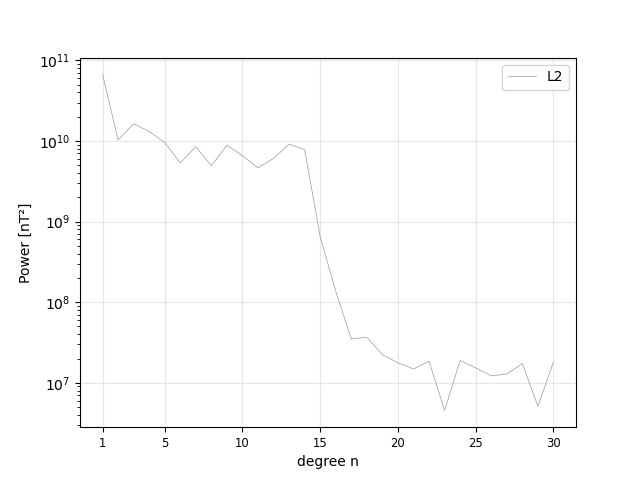

In [16]:
g_spec = model_L2

print(g_spec.shape)

step = 5
nmax = shc_g
r_ref = core.a
p_spec_height = core.r_cmb
legend_loc = "best"

fig = plt.figure()
ns = np.arange(1,nmax+1)
n_ticks = np.append(np.array([1, 5, 10,]),np.arange(15,np.max(ns)+step,step=step))

ens_cilm = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,),g_spec))))
p_spec = pyshtools.gravmag.mag_spectrum(ens_cilm, r_ref, p_spec_height, degrees = np.arange(1,np.shape(ens_cilm)[1]))
p_spec = p_spec[:nmax]
plt.plot(ns, p_spec, color=(0.6,0.6,0.6), label = "L2", linewidth = 0.5)
    
plt.yscale('log')
plt.xlabel("degree n")
plt.ylabel("Power [nT²]")
plt.xticks(n_ticks, fontsize="small")
plt.grid(alpha=0.3)
plt.legend(loc = legend_loc)
fig.canvas.draw()

<IPython.core.display.Javascript object>


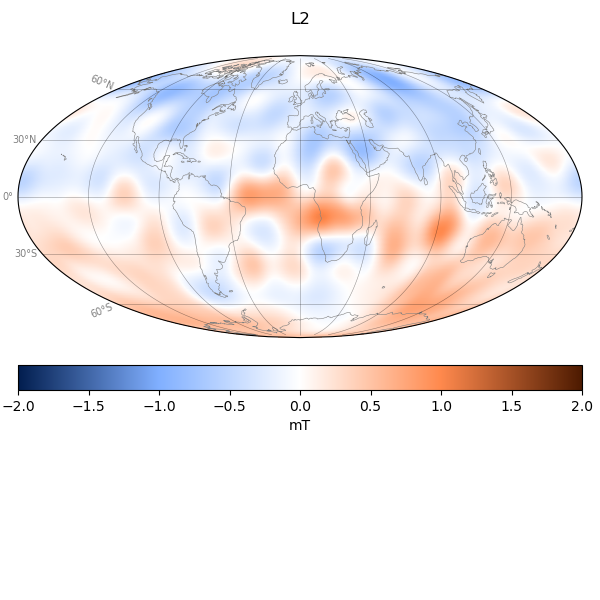

In [17]:
core.grid_glq(nmax = 400, r_at = core.r_cmb)
core.ensemble_B(model_L2, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
Br_l2 = core.B_ensemble[:,0].copy()

limit_data = [-2,2]
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=Br_l2, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='L2', point_size=1,
                savefig = False, save_dpi = 100, save_string ="Br_l2",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

# L1-reg

In [30]:
alpha = 5.68e-4
kappa = 1e-3
# Huber weights, initialised as identity
wh = np.ones(len(obs_sat.data))

# Setup weight matrix:
W = np.diag(obs_sat.ce_inv * wh)

# for every new alpha, start up with initial guess:
gamma = np.ones(Gr_cmb.shape[0])
Ws = np.diag(1 / np.sqrt(gamma ** 2 + kappa ** 2))

# initialise L1-regularised model
rhs = G.T.dot(W.dot(obs_sat.data))
lhs = G.T.dot(W.dot(G)) + alpha**2 * Gr_cmb.T.dot(Ws).dot(Gr_cmb)
model_previous = np.linalg.solve(lhs, rhs)

convergence_limit = 5e-4
# set convergence arbitrarily higher than convergence limit
convergence = convergence_limit + 1

for i in range(int(1e6)):
    if convergence < convergence_limit:
        break
    print(i, convergence)
    # compute gamma
    gamma = Gr_cmb.dot(model_previous)

    # update the L1 weight matrix
    Ws = np.diag(1 / np.sqrt(gamma ** 2 + kappa ** 2))

    # solve for inverse problem
    rhs = G.T.dot(W.dot(obs_sat.data))
    lhs = G.T.dot(W.dot(G)) + alpha**2 * Gr_cmb.T.dot(Ws).dot(Gr_cmb)
    model_current = np.linalg.solve(lhs, rhs)

    # calculate normalised residual
    residual = (obs_sat.data - G.dot(model_current)) * np.sqrt(obs_sat.ce_inv)

    # update Huber weights
    wh = np.fmin(np.ones(residual.size), np.abs(c/residual))

    # update weighting matrix
    W = np.diag(obs_sat.ce_inv * wh)

    # compute convergence parameter
    convergence = np.sqrt(np.linalg.norm(model_current - model_previous) / np.linalg.norm(model_current))
    model_previous = np.copy(model_current)
    
model_L1 = model_current.copy()

0 1.0005
1 0.06978575474995445
2 0.007328488294570094
3 0.004107365982347878
4 0.0029282450592072345
5 0.0023051441715757418
6 0.0019033512553808237
7 0.001661625160550654
8 0.0015078325602049052
9 0.0013897765554669334
10 0.0013167961404088923
11 0.001276870991389756
12 0.0012133890989246571
13 0.0011537828630587845
14 0.0011019749787917585
15 0.001047719916918004
16 0.0009938031980648654
17 0.000948808537750225
18 0.0009151576745722421
19 0.0008830269943580751
20 0.0008506664580127108
21 0.0008214083526999549
22 0.0007979305691087332
23 0.0007795722489117081
24 0.0007639968088707359
25 0.0007491982863473069
26 0.0007336282156021881
27 0.0007177801535144597
28 0.000700162219749502
29 0.0006809646091930408
30 0.0006636718626076512
31 0.0006479048191541833
32 0.0006339509398676733
33 0.0006198287083484942
34 0.0006072039848818935
35 0.0005958431523500465
36 0.0005868495067265096
37 0.0005801779373675931
38 0.0005767253881224597
39 0.0005775364818241947
40 0.0005823796778457978
41 0.0005

# MaxEnt

In [31]:
# Log range of alphas
#spacing, alpha_min, alpha_max = 25, -4.5, -2.2
#list_of_alphas = np.logspace(alpha_min, alpha_max, spacing)

# omega
omega = 5e11
alpha = 6.94e-5

# Huber weights, initialised as identity
wh = np.ones(len(obs_sat.data))

# Use L2 regularised model found earlier as the initial model
model_previous = np.zeros(model_L2.shape)

convergence_limit = 5e-4
# initial while loop condition: a number higher than convergence limit
convergence = convergence_limit + 1

for i in range(int(1e6)):
    if convergence < convergence_limit:
        break
        
    print(i, convergence)
        
    # compute Br at CMB based on previous model
    Br_cmb = Gr_cmb.dot(model_previous)

    # define max entropy variables
    psi = np.sqrt(Br_cmb**2 + 4 * omega**2)
    eta_i = (4 * omega) / psi
    eta_n = Gr_cmb.T.dot(np.diag(eta_i)).dot(Gr_cmb)
    beta = np.log((psi + Br_cmb) / (2 * omega))

    # solve the inverse problem
    lhs = 2 * G.T.dot(W).dot(G) + alpha**2 * eta_n
    rhs = 2 * G.T.dot(W).dot(obs_sat.data) + alpha**2 * (eta_n.dot(model_previous) - 4 * omega * alpha**2 * (Gr_cmb.T.dot(beta)))
    model_current = np.linalg.solve(lhs, rhs)

    # calculate residual
    residual = (obs_sat.data - G.dot(model_current)) * np.sqrt(obs_sat.ce_inv)

    # update Huber weights
    wh = np.fmin(np.ones(residual.size), np.abs(c/residual))

    # update weights
    W = np.diag(obs_sat.ce_inv * wh)

    # compute convergence parameter
    convergence = np.sqrt(np.linalg.norm(model_current - model_previous) / np.linalg.norm(model_current))

    # update model
    model_previous = np.copy(model_current)
    
model_Ent = model_current.copy()

0 1.0005
1 1.0
2 0.014725336353941916
3 0.013431717831104978
4 0.012677079129050195
5 0.011977485567169637
6 0.011188431048972417
7 0.010247756199819073
8 0.009160352644493176
9 0.008098725390707493
10 0.0072443769831398094
11 0.006516206518819777
12 0.005943135156180238
13 0.005485007454546219
14 0.0050815843984604115
15 0.004668495638259392
16 0.004294008721127147
17 0.004004536080439922
18 0.0037766223397850862
19 0.0035280606275167187
20 0.003345179507301721
21 0.003213742508752255
22 0.003099692037560811
23 0.0029811114197139635
24 0.002878904601097832
25 0.002796889456148959
26 0.0027152347865615953
27 0.0026378702397355457
28 0.002566030541313162
29 0.002499922156552729
30 0.0024384820454585523
31 0.002381099392487924
32 0.002327525825439501
33 0.002277180940331118
34 0.002229610593822153
35 0.002184935438136528
36 0.002142147154647709
37 0.002098307138840201
38 0.0020554880382840117
39 0.002004650819736585
40 0.0019609435095008887
41 0.0019218138005597807
42 0.00188499542029278

<IPython.core.display.Javascript object>


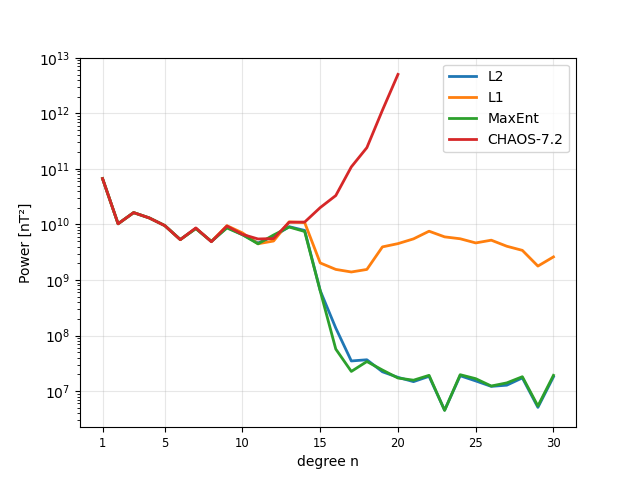

In [32]:
step = 5
nmax = shc_g
r_ref = core.a
p_spec_height = core.r_cmb
legend_loc = "best"

g_CHAOS7_n20 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=20, deriv=0)

fig = plt.figure()
ns = np.arange(1,nmax+1)
n_ticks = np.append(np.array([1, 5, 10,]),np.arange(15,np.max(ns)+step,step=step))

ens_cilm = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,),model_L2))))
p_spec = pyshtools.gravmag.mag_spectrum(ens_cilm, r_ref, p_spec_height, degrees = np.arange(1,np.shape(ens_cilm)[1]))
p_spec_L2 = p_spec[:nmax]

ens_cilm = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,),model_L1))))
p_spec = pyshtools.gravmag.mag_spectrum(ens_cilm, r_ref, p_spec_height, degrees = np.arange(1,np.shape(ens_cilm)[1]))
p_spec_L1 = p_spec[:nmax]

ens_cilm = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,),model_Ent))))
p_spec = pyshtools.gravmag.mag_spectrum(ens_cilm, r_ref, p_spec_height, degrees = np.arange(1,np.shape(ens_cilm)[1]))
p_spec_Ent = p_spec[:nmax]

ens_cilm = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,),g_CHAOS7_n20))))
p_spec = pyshtools.gravmag.mag_spectrum(ens_cilm, r_ref, p_spec_height, degrees = np.arange(1,np.shape(ens_cilm)[1]))
p_spec_C7 = p_spec[:nmax]

plt.plot(ns, p_spec_L2, color="C0", label = "L2", linewidth = 2)
plt.plot(ns, p_spec_L1, color="C1", label = "L1", linewidth = 2)
plt.plot(ns, p_spec_Ent, color="C2", label = "MaxEnt", linewidth = 2)
plt.plot(ns[:20], p_spec_C7, color="C3", label = "CHAOS-7.2", linewidth = 2)

plt.yscale('log')
plt.xlabel("degree n")
plt.ylabel("Power [nT²]")
plt.xticks(n_ticks, fontsize="small")
plt.grid(alpha=0.3)
plt.legend(loc = legend_loc)
fig.canvas.draw()

<IPython.core.display.Javascript object>


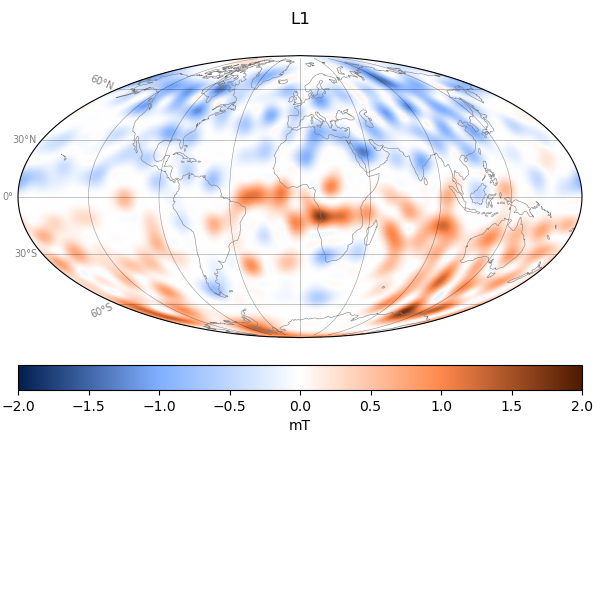

<IPython.core.display.Javascript object>


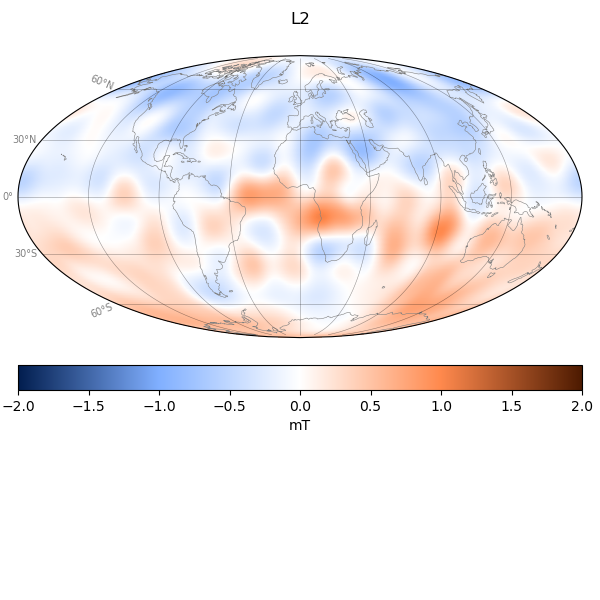

<IPython.core.display.Javascript object>


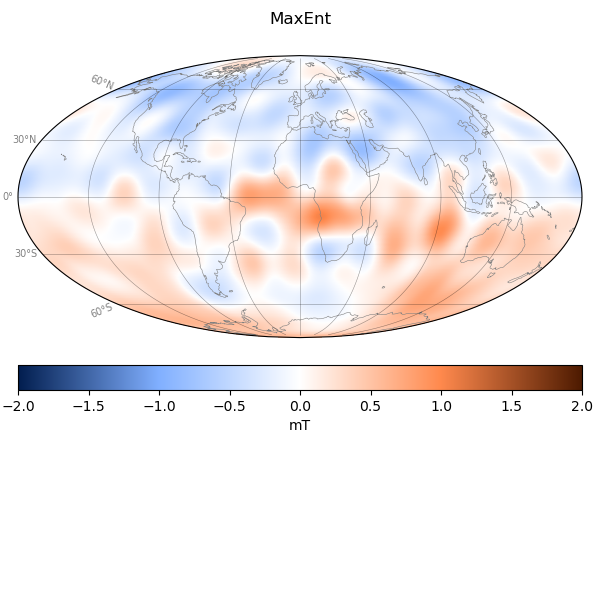

<IPython.core.display.Javascript object>


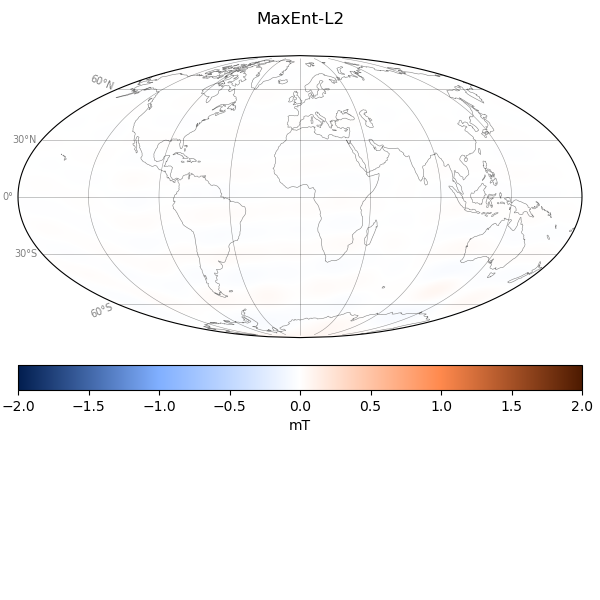

In [33]:
core.grid_glq(nmax = 400, r_at = core.r_cmb)

core.ensemble_B(model_L2, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
Br_l2 = core.B_ensemble[:,0].copy()

core.ensemble_B(model_L1, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
Br_l1 = core.B_ensemble[:,0].copy()

core.ensemble_B(model_Ent, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
Br_ent = core.B_ensemble[:,0].copy()

limit_data = [-2,2]
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=Br_l1, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='L1', point_size=1,
                savefig = False, save_dpi = 100, save_string ="Br_l1",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=Br_l2, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='L2', point_size=1,
                savefig = False, save_dpi = 100, save_string ="Br_l2",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=Br_ent, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='MaxEnt', point_size=1,
                savefig = False, save_dpi = 100, save_string ="Br_ent",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)


mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=Br_ent-Br_l2, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='MaxEnt-L2', point_size=1,
                savefig = False, save_dpi = 100, save_string ="Br_diff",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)